In [16]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from statsmodels.tsa.deterministic import DeterministicProcess

from sklearn.linear_model import LinearRegression

simplefilter("ignore")  # ignore warnings to clean up output cells

In [17]:
# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [18]:
# Load Tunnel Traffic dataset
data_dir = Path("../Datasets/TS_Course_Data")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])
tunnel.head()


,Day,NumVehicles
0,2003-11-01,103536
1,2003-11-02,92051
2,2003-11-03,100795
3,2003-11-04,102352
4,2003-11-05,106569


In [19]:
tunnel = tunnel.set_index("Day").to_period()
# Changes the index to the values in the "Day" Column
# to_period() converts DateTimeIndex to a PeriodIndex
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


<Axes: title={'center': 'Tunnel Traffic - 365-Day Moving Average'}, xlabel='Day'>

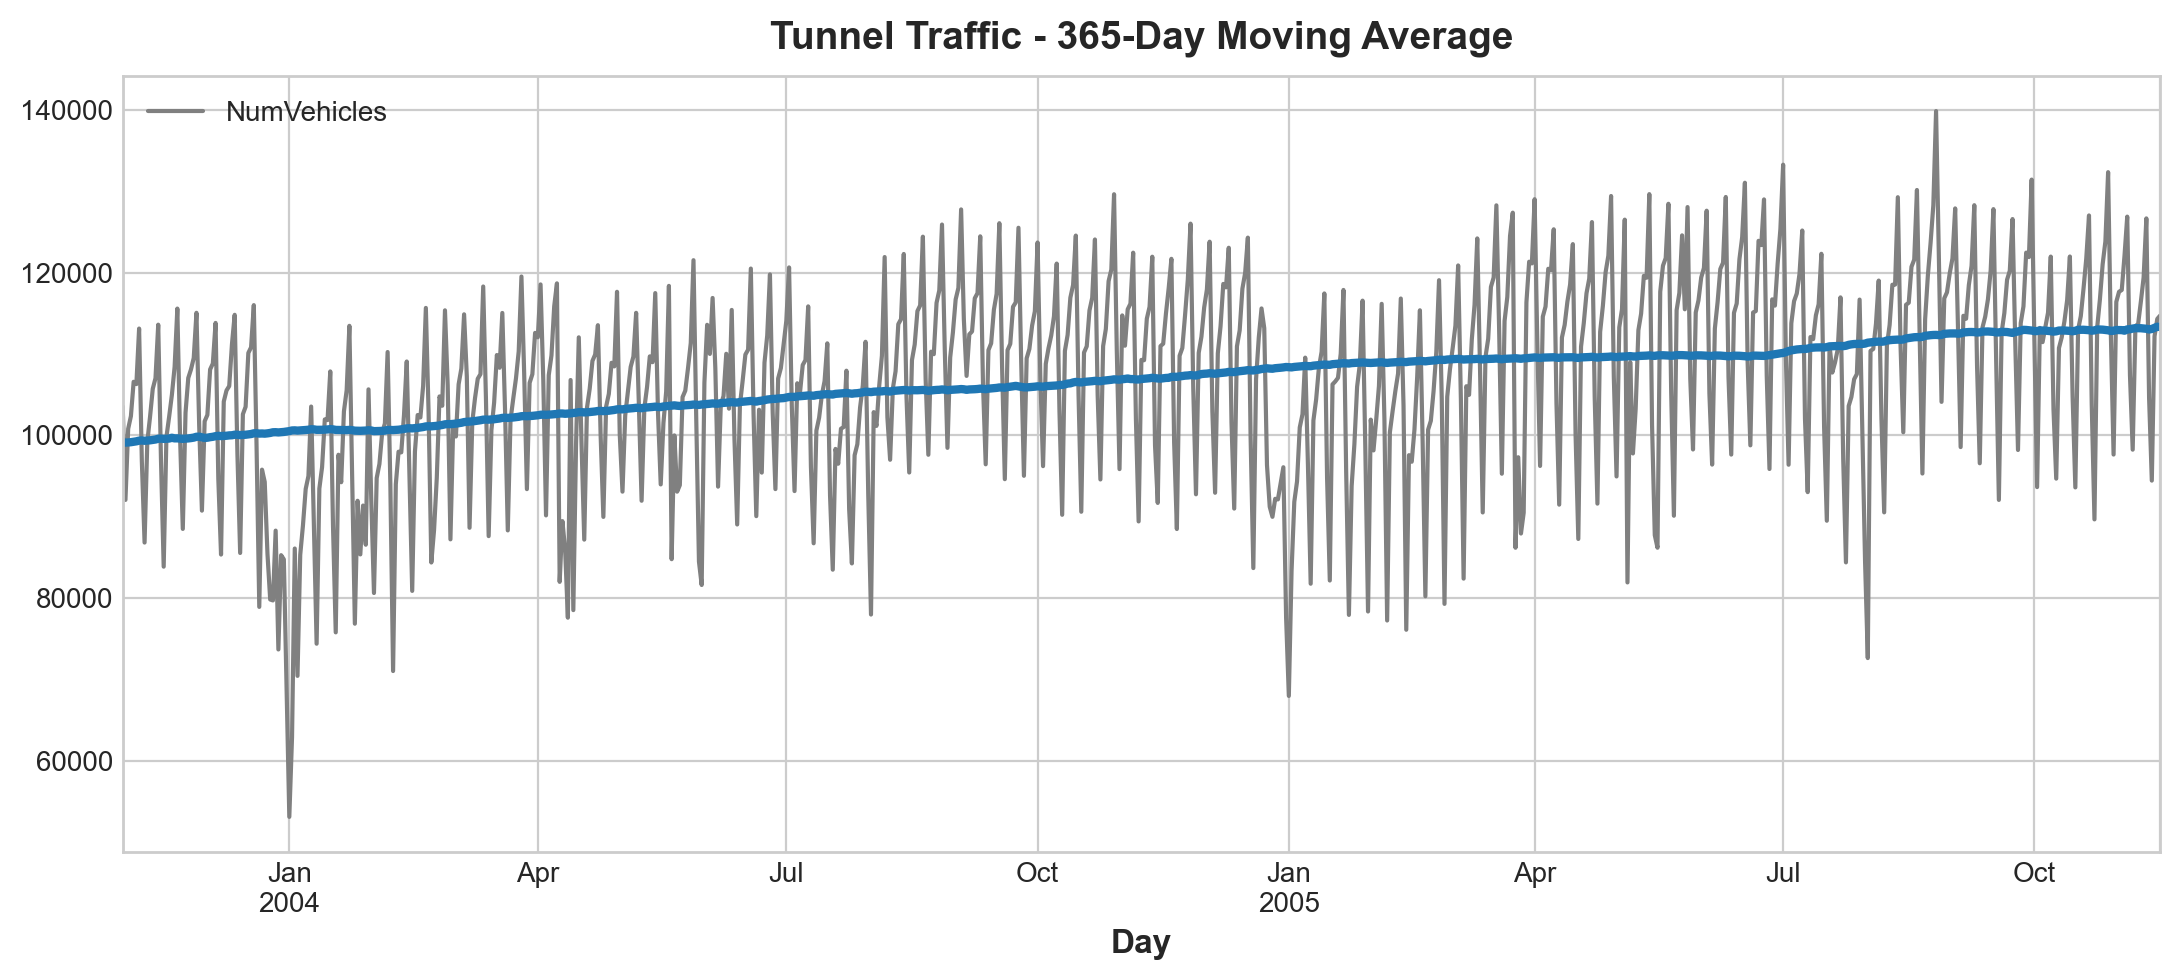

In [27]:
moving_average = tunnel.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

# min_periods=183 parameter ensures that a value 
# is calculated only if there are at least 183 non-NA values within the window
# The result is a new DataFrame (moving_average) where each point 
# represents the average of the previous 365 days centered around that point, 
# with at least 183 data points required to calculate an average.
ax = tunnel.plot(style="-", color="0.5")
# Plots data: - (line),. (scatter)
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
)
# plots the moving average

In [28]:
dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# initializes a DeterministicProcess object. 
# This object is used to generate deterministic features (like trends, dummies, etc.) 
# for time series modeling
# order=1: Includes a time trend of order 1, which means it will generate a linear trend feature. 
# This can capture linear growth or decline in the data over time.
# drop=True: Indicates that any terms that could cause collinearity should be dropped.
# This is important for avoiding multicollinearity in regression models, which can distort the results.
X = dp.in_sample()
# `in_sample` creates features for the dates given in the `index` argument
X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


In [22]:
dp.in_sample()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0
...,...,...
2005-11-12,1.0,743.0
2005-11-13,1.0,744.0
2005-11-14,1.0,745.0


In [23]:
y = tunnel["NumVehicles"]  # the target
# This line extracts the target variable NumVehicles from the tunnel DataFrame
# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
# Including another intercept would introduce redundancy and 
# could lead to poor model performance due to duplicated features.
# This decision is based on the fact that your features from the DeterministicProcess 
# already include a constant term (constant=True), which acts as the intercept
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

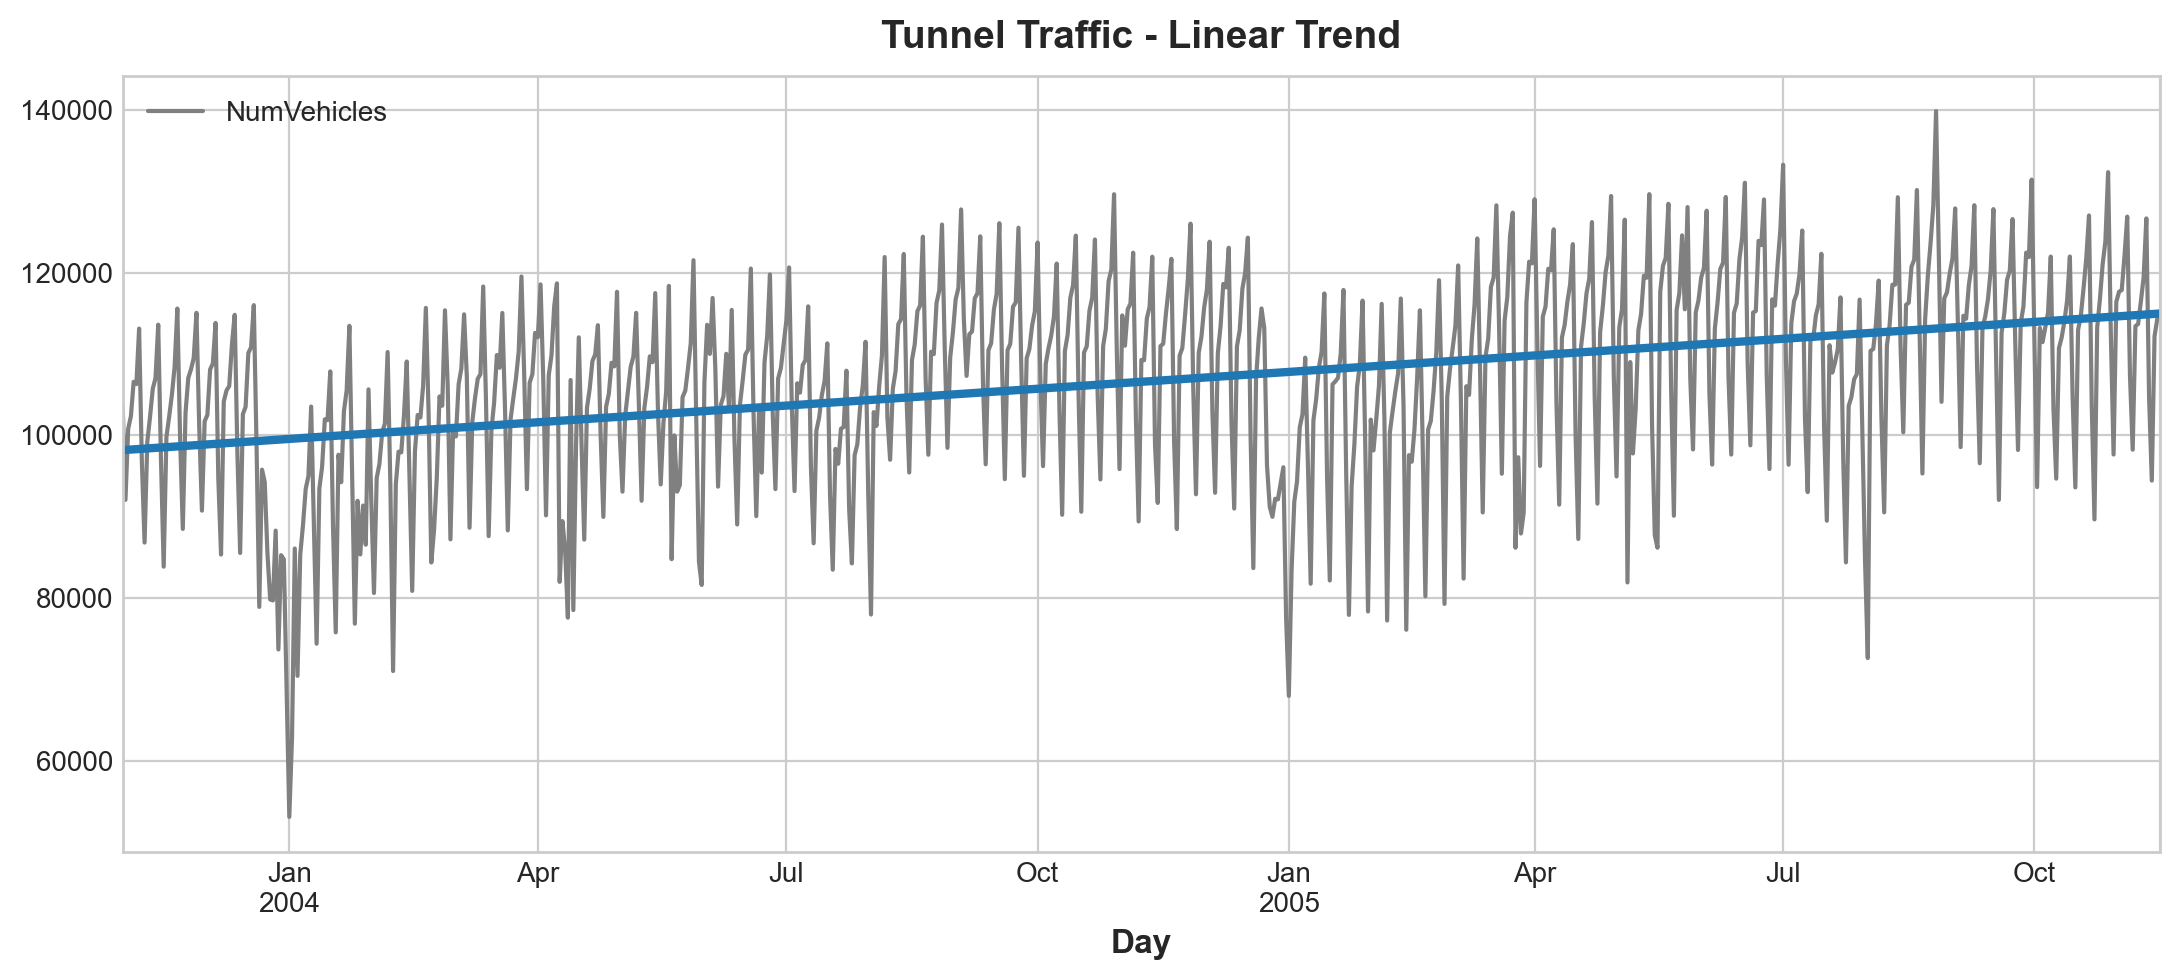

In [29]:
ax = tunnel.plot(style="-", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [25]:
X = dp.out_of_sample(steps=30)
# This line uses the out_of_sample method of the DeterministicProcess object dp to generate 
# features for future dates, extending beyond the original dataset. 
# The steps=30 argument specifies that you want to generate features for 30 periods into the future. 
# This could be 30 days, months, or another time unit depending on the frequency of your original 
# time series data. The resulting X DataFrame will contain the same types of features 
# (e.g., a constant term and a linear trend) as your in-sample features, but for the future dates.
y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

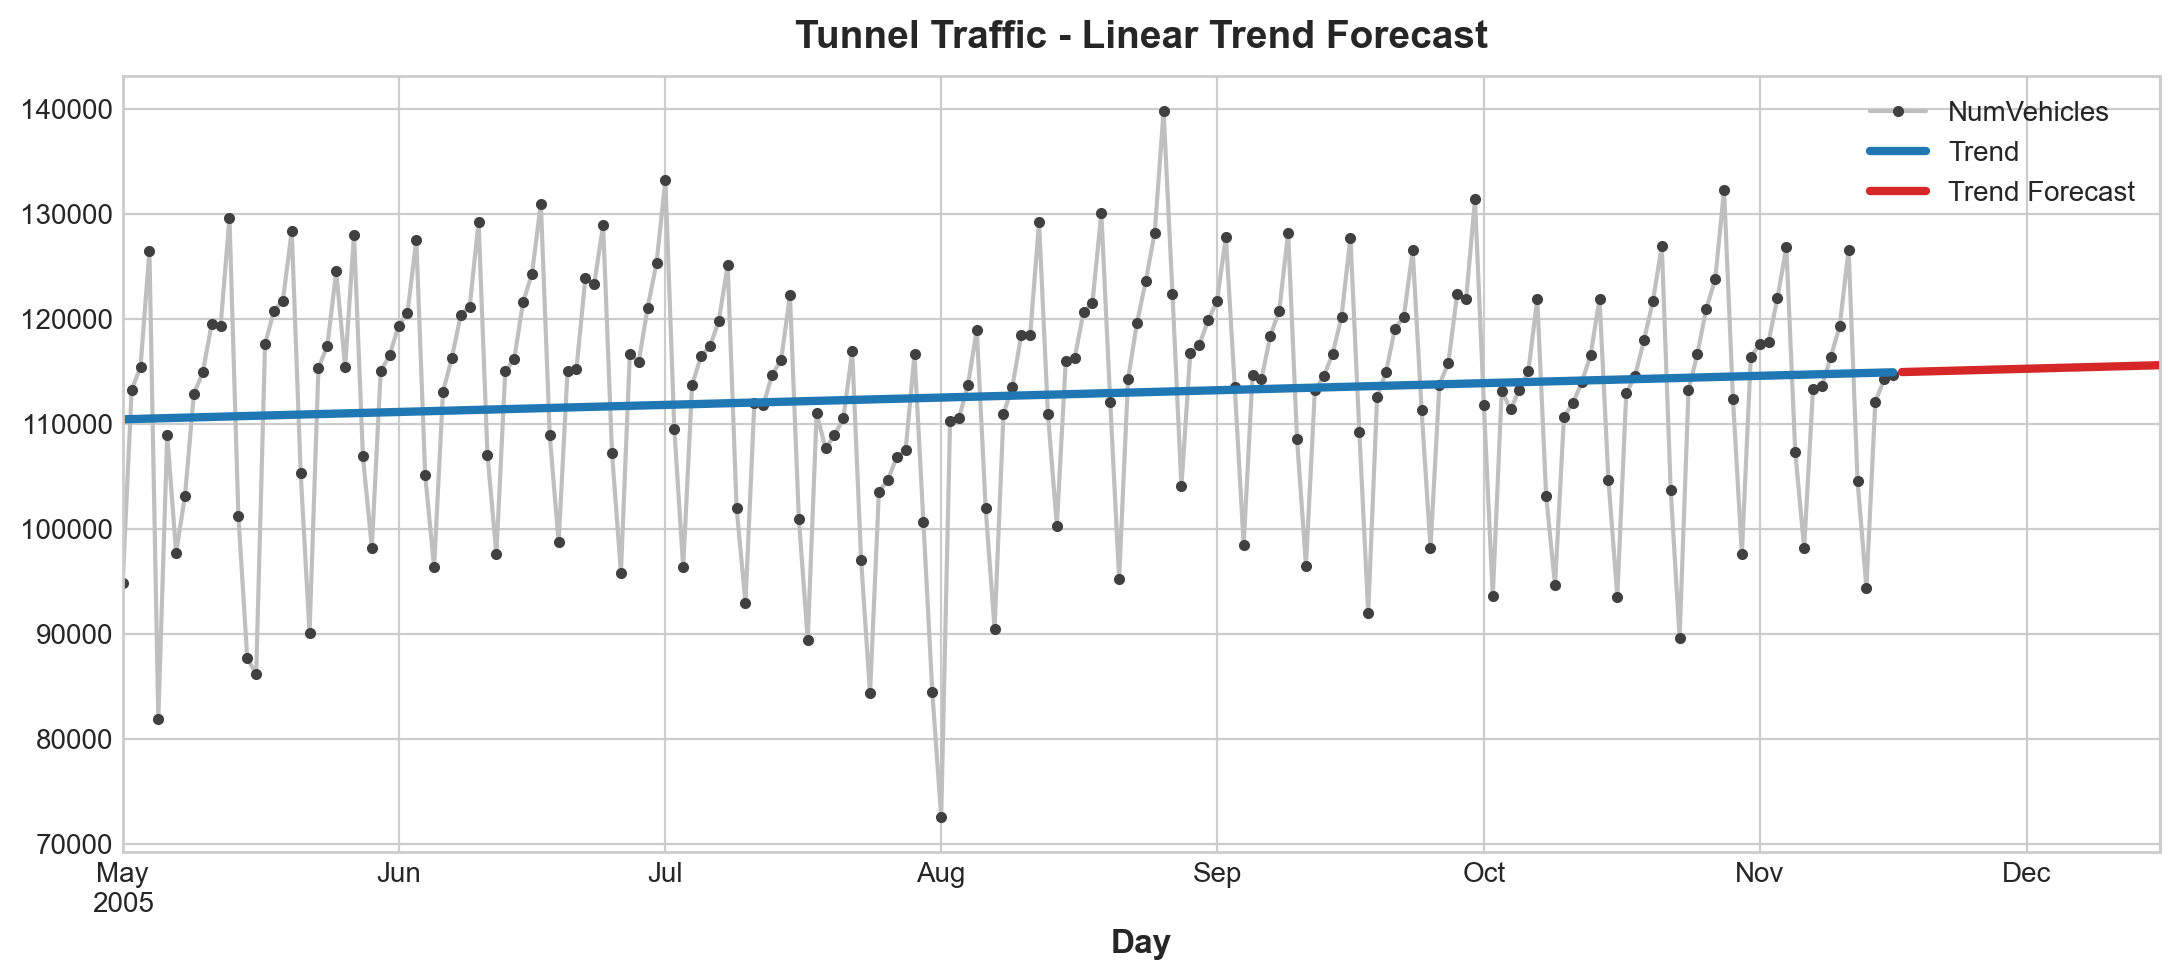

In [26]:
ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
# plots traffic from May 2005 onwards
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
# Historical trend line
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
# plots the forecast
_ = ax.legend()
# The labels provided in the previous plotting commands ("Trend" and "Trend Forecast") 
# are used in the legend to identify each line.